<a href="https://colab.research.google.com/github/leofardo/tech_challenge_fase_2_fiap/blob/main/TECH_CHALLENGE_FIAP_FASE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Linear Regression

> 1. Regressão contínua:
Prever o valor do retorno do Ibovespa do dia seguinte como um número decimal:
y = retorno_tomorrow  # ex: 0.0035 → subiu 0,35%

> 2. Converter isso em 0 ou 1 com um limiar (threshold):
y_pred_bin = (y_pred > 0.005).astype(int)  # 1 se subir mais que 0,5%

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# Carregando os dados
df = pd.read_csv("/content/Dados Históricos - Ibovespa.csv", dtype=str)

df["preco_hoje"] = df["Último"].apply(lambda x: int(x.replace(".", "")))
df["Abertura"] = df["Abertura"].apply(lambda x: int(x.replace(".", "")))
df["Data"] = pd.to_datetime(df["Data"], format="%d.%m.%Y")
df = df.sort_values("Data").reset_index(drop=True)
df.drop(columns={"Último"}, axis=1, inplace=True)
df

,Data,Abertura,Máxima,Mínima,Vol.,Var%,preco_hoje
0,2005-07-11,24425,25.032,24.425,"100,42M","2,43%",25016
1,2005-07-12,25027,25.576,24.932,"94,91M","2,08%",25536
2,2005-07-13,25557,26.043,25.557,"107,28M","1,25%",25856
3,2005-07-14,25859,26.142,25.725,"113,35M","0,25%",25920
4,2005-07-15,25916,25.916,25.222,"72,88M","-2,69%",25222
...,...,...,...,...,...,...,...
4948,2025-07-03,139051,141.304,139.051,"6,08B","1,35%",140928
4949,2025-07-04,140928,141.564,140.597,"3,31B","0,24%",141264
4950,2025-07-07,141265,141.342,139.295,"6,12B","-1,26%",139490
4951,2025-07-08,139491,139.591,138.770,"6,75B","-0,13%",139303


In [2]:

# Target de regressão: retorno do dia seguinte
df["retorno_tomorrow"] = df["preco_hoje"].shift(-1) / df["preco_hoje"] - 1

# Features baseadas no passado
df["retorno_diario"] = (df["preco_hoje"] - df["Abertura"]) / df["Abertura"]
df["lag_1"] = df["preco_hoje"].shift(1)
df["lag_2"] = df["preco_hoje"].shift(2)
df["lag_3"] = df["preco_hoje"].shift(3)
df["mm3"] = df["preco_hoje"].rolling(3).mean()
df["mm5"] = df["preco_hoje"].rolling(5).mean()
df["volatilidade_5d"] = df["preco_hoje"].rolling(5).std()
df = df.dropna().reset_index(drop=True)

df


,Data,Abertura,Máxima,Mínima,Vol.,Var%,preco_hoje,retorno_tomorrow,retorno_diario,lag_1,lag_2,lag_3,mm3,mm5,volatilidade_5d
0,2005-07-15,25916,25.916,25.222,"72,88M","-2,69%",25222,0.003925,-0.026779,25920.0,25856.0,25536.0,25666.000000,25510.0,392.260118
1,2005-07-18,25222,25.412,24.916,"52,17M","0,39%",25321,-0.001975,0.003925,25222.0,25920.0,25856.0,25487.666667,25571.0,311.669697
2,2005-07-19,25312,25.312,24.960,"119,27M","-0,20%",25271,0.017174,-0.001620,25321.0,25222.0,25920.0,25271.333333,25518.0,340.324110
3,2005-07-20,25268,25.795,24.970,"130,63M","1,72%",25705,0.005330,0.017295,25271.0,25321.0,25222.0,25432.333333,25487.8,307.996266
4,2005-07-21,25706,25.964,25.505,"109,50M","0,53%",25842,-0.017452,0.005291,25705.0,25271.0,25321.0,25606.000000,25472.2,281.465273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,2025-07-02,139586,140.049,138.384,"8,81B","-0,36%",139051,0.013499,-0.003833,139549.0,138855.0,136866.0,139151.666667,138287.0,1213.891882
4943,2025-07-03,139051,141.304,139.051,"6,08B","1,35%",140928,0.002384,0.013499,139051.0,139549.0,138855.0,139842.666667,139049.8,1464.903307
4944,2025-07-04,140928,141.564,140.597,"3,31B","0,24%",141264,-0.012558,0.002384,140928.0,139051.0,139549.0,140414.333333,139929.4,1101.020572
4945,2025-07-07,141265,141.342,139.295,"6,12B","-1,26%",139490,-0.001341,-0.012565,141264.0,140928.0,139051.0,140560.666667,140056.4,975.586644


In [3]:
# Separação de X e y
X = df[["retorno_diario", "lag_1", "lag_2", "lag_3", "mm3", "mm5", "volatilidade_5d"]]
y = df["retorno_tomorrow"]

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled


array([[-1.65067102, -1.66027396, -1.66199964, ..., -1.66941874,
        -1.67469796, -0.83897623],
       [ 0.20926996, -1.68392286, -1.65983082, ..., -1.6754628 ,
        -1.67262959, -0.96811865],
       [-0.12662284, -1.68056865, -1.68348452, ..., -1.68279474,
        -1.6744267 , -0.92220128],
       ...,
       [ 0.11592459,  2.23630503,  2.17393131, ...,  2.2196196 ,
         2.20498783,  0.2967796 ],
       [-0.78964864,  2.24768902,  2.23753873, ...,  2.22457912,
         2.20929409,  0.09577753],
       [-0.11014433,  2.18758424,  2.24892504, ...,  2.20622101,
         2.20762584,  0.15582063]])

In [4]:
# Treino (até n-30) e teste (últimos 30 dias)
n_test = 30
X_train, X_test = X_scaled[:-n_test], X_scaled[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

# Treina regressão
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Avaliação contínua
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.6f}, R²: {r2:.4f}")

# Classificação baseada em threshold
threshold = 0.005  # 0.5%
y_test_bin = (y_test > threshold).astype(int)
y_pred_bin = (y_pred > threshold).astype(int)
acc = accuracy_score(y_test_bin, y_pred_bin)
print(f"Acurácia da regressão convertida em classificação: {acc:.2%}")

MSE: 0.000055, R²: 0.0294
Acurácia da regressão convertida em classificação: 76.67%


In [5]:
# Previsão real do próximo dia
X_hoje = df[["retorno_diario", "lag_1", "lag_2", "lag_3", "mm3", "mm5", "volatilidade_5d"]].iloc[-1:]
X_hoje_scaled = scaler.transform(X_hoje)
retorno_previsto = model.predict(X_hoje_scaled)[0]
retorno_previsto

np.float64(-0.000832946472149405)

In [6]:
retorno_previsto = model.predict(X_hoje_scaled)[0]

if retorno_previsto > threshold:
    print("Ibovespa deve subir.")
else:
    print("Ibovespa deve cair.")


Ibovespa deve cair.


O modelo acredita que o Ibovespa vai cair  0,83% no próximo dia.

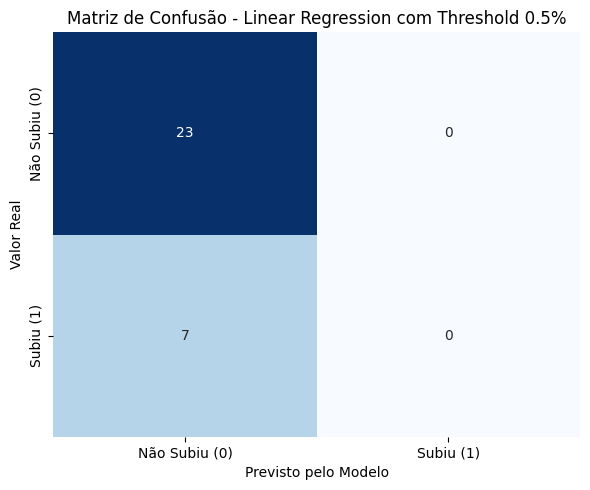

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matriz de confusão real
cm = confusion_matrix(y_test_bin, y_pred_bin)
labels = ["Não Subiu (0)", "Subiu (1)"]

# Plot elegante
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Previsto pelo Modelo")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusão - Linear Regression com Threshold 0.5%")
plt.tight_layout()
plt.show()


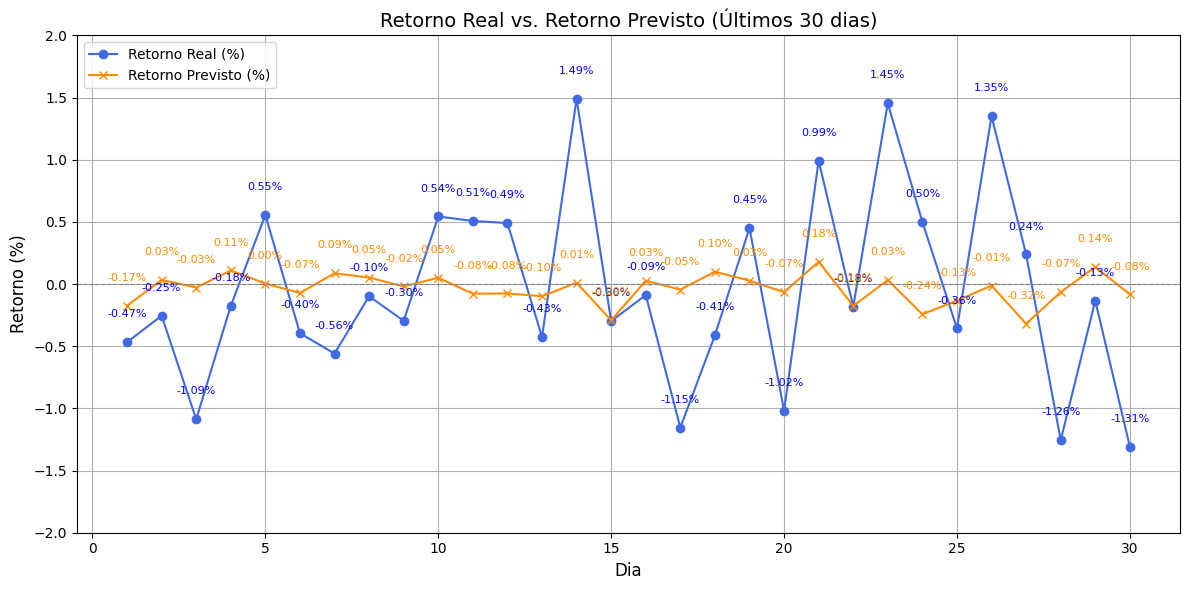

In [8]:
import matplotlib.pyplot as plt
import numpy as np

dias = np.arange(1, len(y_test) + 1)

plt.figure(figsize=(12, 6))
plt.plot(dias, y_test * 100, label="Retorno Real (%)", marker='o', color='royalblue')
plt.plot(dias, y_pred * 100, label="Retorno Previsto (%)", marker='x', color='darkorange')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Limites do eixo Y (ajustável conforme seus dados)
plt.ylim(-2, 2)

# Adiciona rótulos nos pontos (opcional, pode comentar se ficar poluído)
for i in range(len(dias)):
    plt.text(dias[i], (y_test.iloc[i] * 100) + 0.2, f"{y_test.iloc[i]*100:.2f}%", ha='center', fontsize=8, color='blue')
    plt.text(dias[i], (y_pred[i] * 100) +0.2, f"{y_pred[i]*100:.2f}%", ha='center', fontsize=8, color='darkorange')

plt.title("Retorno Real vs. Retorno Previsto (Últimos 30 dias)", fontsize=14)
plt.xlabel("Dia", fontsize=12)
plt.ylabel("Retorno (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# RANDOM FOREST

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report


# Modelo com Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Avaliação Regressão
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.6f}, R²: {r2:.4f}")

# Classificação com threshold
threshold = 0.005  # 0.5%
y_test_bin = (y_test > threshold).astype(int)
y_pred_bin = (y_pred > threshold).astype(int)
acc = accuracy_score(y_test_bin, y_pred_bin)
print(f"Acurácia da regressão convertida em classificação: {acc:.2%}")

# Matriz de confusão
print(confusion_matrix(y_test_bin, y_pred_bin))


# Previsão do próximo dia
X_hoje = X.iloc[[-1]]
X_hoje_scaled = scaler.transform(X_hoje)
retorno_previsto = model.predict(X_hoje_scaled)[0]
print(f"Previsão do próximo dia: {retorno_previsto:.4%}")

MSE: 0.000061, R²: -0.0740
Acurácia da regressão convertida em classificação: 73.33%
[[22  1]
 [ 7  0]]
Previsão do próximo dia: 0.2562%


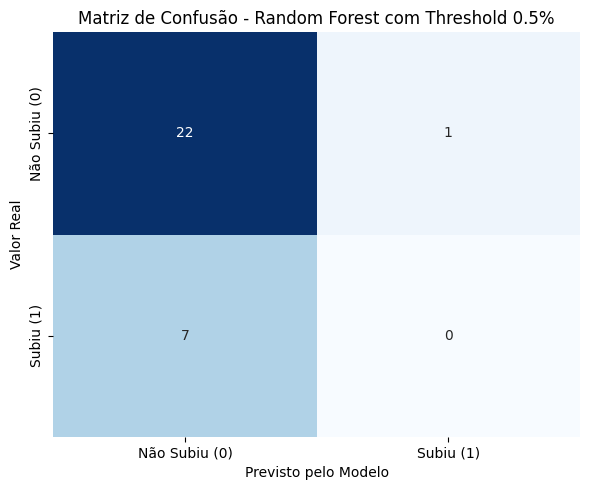

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matriz de confusão real
cm = confusion_matrix(y_test_bin, y_pred_bin)
labels = ["Não Subiu (0)", "Subiu (1)"]

# Plot elegante
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Previsto pelo Modelo")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusão - Random Forest com Threshold 0.5%")
plt.tight_layout()
plt.show()
